This is a demonstration of a 2-D CNN used for Image Classification

In [93]:
import torch

from torch import nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


import matplotlib.pyplot as plt

# Load MNIST dataset

In [ ]:
digits_dataset = MNIST(
    root='../../data', # the folder where data eixsts/is stored,
    download=True,
    transform=ToTensor() # The image are PIL format, this transform to Tensor objects
)
print(digits_dataset.data.shape)

# Defining previous architecture and loading pre-trained weights

In [5]:
class ConvolutionLayer(nn.Module):
    def __init__(self,
        in_chan: int,
        out_chan: int,
        activation_fn: nn.Module,
        kern_size: int = 3,
        pool_kern: int = 2
    ):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Conv2d(
                in_channels=in_chan,
                out_channels=out_chan,
                kernel_size=kern_size,
                padding='same'
            ),
            activation_fn,
            nn.MaxPool2d(pool_kern)
        )

    def forward(self, in_data):
        return self.layer(in_data)

In [6]:
in_features = 4 * 28 * 28 // (2 ** (2 * 2))

conv_net_50p = nn.Sequential(
    ConvolutionLayer(1, 32, nn.ReLU()),
    ConvolutionLayer(32, 4, nn.ReLU()),

    nn.Flatten(),
    nn.Linear(in_features, 50), nn.ReLU(),
    nn.Linear(50, 50), nn.ReLU(),
    nn.Linear(50, 10)
)
conv_net_100p = nn.Sequential(
    ConvolutionLayer(1, 32, nn.ReLU()),
    ConvolutionLayer(32, 4, nn.ReLU()),

    nn.Flatten(),
    nn.Linear(in_features, 100), nn.ReLU(),
    nn.Linear(100, 100), nn.ReLU(),
    nn.Linear(100, 10)
)

In [7]:
checkpoints = [
    torch.load('./output/cnn_demo_3Layer_50Perc.pth', map_location='cpu'),
    torch.load('./output/cnn_demo_3Layer_100Perc.pth', map_location='cpu')
]
# checkpoints[0]['']

conv_net_50p.load_state_dict(checkpoints[0]['model_dict'])
conv_net_100p.load_state_dict(checkpoints[1]['model_dict'])

conv_net_50p.eval()
conv_net_100p.eval();

# Interpreting the Weights

In [62]:
def draw_filters(sample_image, convolved_filters, fig=None):
    cmap = 'gray_r'
    layout = [
        ['Image', 0, 1],
        ['Image', 2, 3]
    ]

    if fig is None:
        fig = plt.figure(figsize=(10, 5))
    axes = fig.subplot_mosaic(layout, width_ratios=(2, 1, 1))

    axes['Image'].imshow(sample_image[0, :, :], cmap=cmap)
    axes['Image'].set_title('Original Image')
    axes['Image'].set_xticks([])
    axes['Image'].set_yticks([])
    for i in range(4):
        axes[i].set_title(f'Filter {i}')
        axes[i].imshow(convolved_filters[i, :, :], cmap=cmap)
        axes[i].set_xticks([])
        axes[i].set_yticks([])

We observe the information extracted in each filters after the two convolutional layers.\
We choose a sample image first.

In [89]:
number = 1
indices = (digits_dataset.targets == number).argwhere()

sample_image = digits_dataset[indices[5].item()][0]
sample_image.shape

torch.Size([1, 28, 28])

We first consider the CNN with 50 perceptrons for the last Fully Connected Layers.

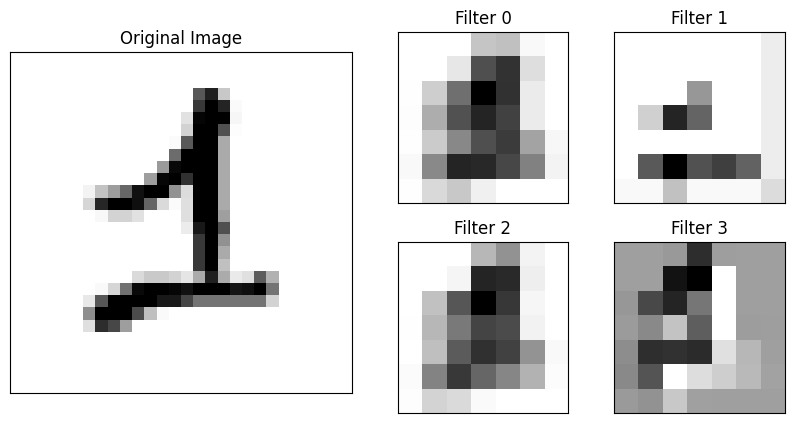

In [90]:
# remember to call detach to detach the weights and biases from the gradients
layers_50 = list(conv_net_50p.children())
convolved_input = layers_50[1](layers_50[0](sample_image)).detach()
draw_filters(sample_image, convolved_input)

We then consider the CNN with 100 perceptrons for the last Fully Connected Layers.

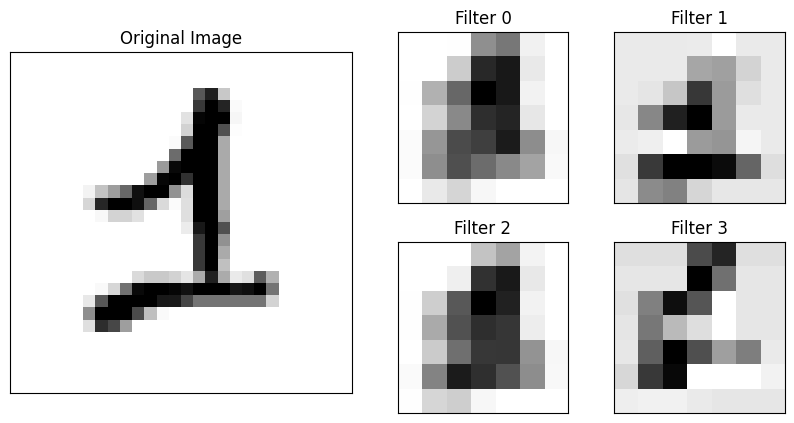

In [91]:
layers_100 = list(conv_net_100p.children())
convolved_input = layers_100[1](layers_100[0](sample_image)).detach()
draw_filters(sample_image, convolved_input)

In [92]:
# unsqueeze to pass the image in as a batch rather than sample
predict_vals = (
    conv_net_50p(sample_image.unsqueeze(0)).detach(),
    conv_net_100p(sample_image.unsqueeze(0)).detach(),
)
prediction = (
    predict_vals[0].argmax().item(),
    predict_vals[1].argmax().item(),
)

print('50 Perceptron Model')
print(f"""Output Values:
    {predict_vals[0]}
Prediction: {prediction[0]}""")

print('\n100 Perceptron Model')
print(f"""Output Values:
    {predict_vals[1]}
Prediction: {prediction[1]}""")

50 Perceptron Model
Output Values:
    tensor([[ 0.1507,  0.9432,  2.4346,  1.7338, -2.1223,  1.4237,  1.4559, -3.6162,
          1.5220, -1.6726]])
Prediction: 2

100 Perceptron Model
Output Values:
    tensor([[-0.4341, -0.4903,  2.0937,  3.5750, -4.8494,  1.5722,  1.5238, -2.3102,
          0.5061, -2.3335]])
Prediction: 3


# Inference on unseen data

We already observed how well the model can infer unseen images from the test set.\
One thing we notice is that these images are all 28x28 images. So any new images of different size
can not be predicted by the model.

To solve this issue, we need to change the dimension of the image in some way without losing too much information. For an image with a smaller size than the original 28x28, we can simply add black pixels to the image, which does not add in any unnecessary information to the original image. However, images of larger sizes requires a more contrived method.\
Here, we try the following method of compression the image:
1. Blurring images using Gaussian Blur: This is essentially a 2d Convolution on the image where we use a fixed Gaussian kernel instead of a learned kernel. This acts as a low-pass filter where high/rapid changes in colour gets smoothed out.
2. Downsampling the image respectively in the row and width by choosing every $n$-th .

Furthermore, to easily determine the kernel size for blurring to compress into 28x28 image. We will first 'square' the image by zero-padding the suitable dimension.

Note that instead of using a Gaussian kernel for the convolution, we can use a different kernel like a Box kernel, Hanning kernel, etc.

In [37]:
import torchvision

from torchvision.transforms import GaussianBlur, Grayscale

grayscaler = Grayscale()

In [70]:
def compress_image(
    img: torch.Tensor,
    desired_shape: int,
    sigma: int | float = 5,
    kern_size: int | None = None
):
    if img.shape[1] != img.shape[2]:
        missing_dim = abs(img.shape[1] - img.shape[2])
        if img.shape[1] < img.shape[2]:
            img = nn.functional.pad(img, (0, 0, 0, missing_dim))
        else:
            img = nn.functional.pad(img, (0, missing_dim, 0, 0))


    if img.shape[1] == desired_shape:
        return img

    # Gaussian Blur, the kernel size of 1/4 the image size is taken
    # Note that kernel size must be odd
    if kern_size is None:
        kern_size = img.shape[1] // 4
    if kern_size % 2 == 0: kern_size += 1
    new_img = GaussianBlur(kern_size, sigma)(img)

    # downsample image to best match the desired_shape
    # this however does not ensure a perfect match, so we need to
    # crop out the extra rows and columns afterwards.
    down_sr = new_img.shape[1] // desired_shape
    new_img = new_img[:, ::down_sr, ::down_sr]

    if new_img.shape != (1, 28, 28):
        extra_dims = new_img.shape[1] - 28
        new_img = new_img[:, :-extra_dims, :-extra_dims]    
    return new_img

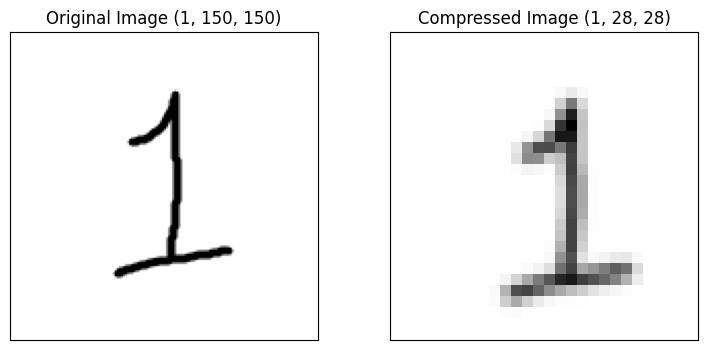

In [86]:
img = torchvision.io.read_image('./data/test_img/num1.2.png')
img = (255 - grayscaler(img[:3])) / 255

lowpass_filtered_image = compress_image(img, 28, 3, 31)


fig = plt.figure(figsize=(9, 4))
axes = fig.subplots(1, 2)
axes[0].set_title(f'Original Image {tuple(img.shape)}')
axes[0].imshow(img[0], cmap='gray_r')
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title(f'Compressed Image {tuple(lowpass_filtered_image.shape)}')
axes[1].imshow(lowpass_filtered_image[0], cmap='gray_r')
axes[1].set_xticks([]);
axes[1].set_yticks([]);

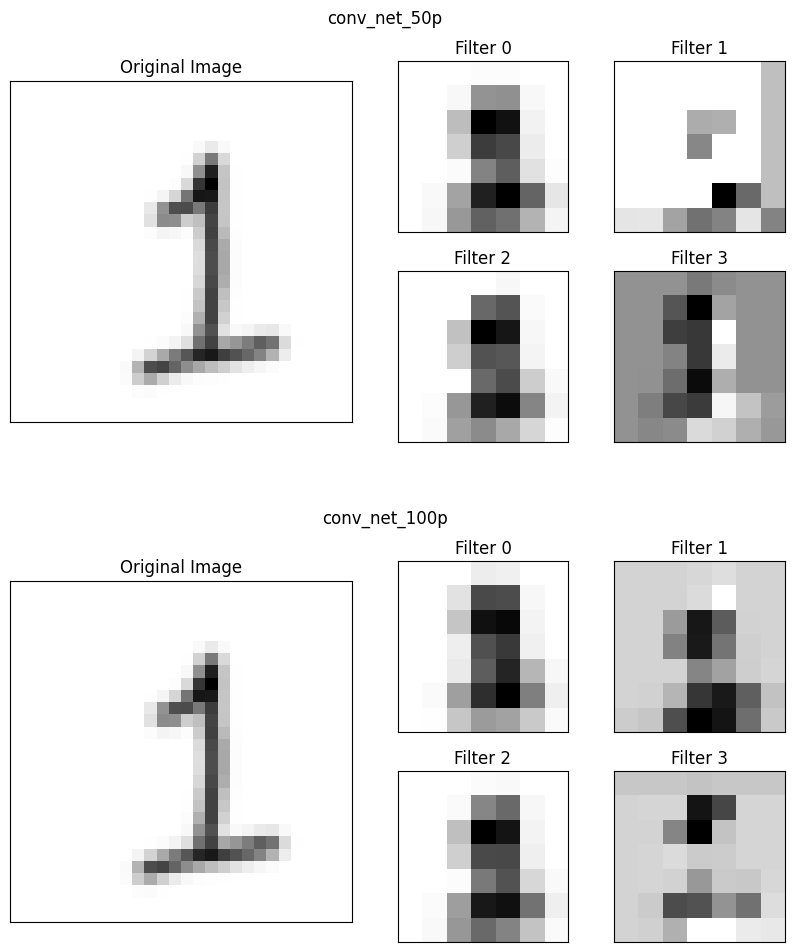

In [87]:
# Reusing the layers extracted from the section above, remember to run those cells!
convolved_input = [
    layers_50[1](layers_50[0](lowpass_filtered_image)).detach(),
    layers_100[1](layers_100[0](lowpass_filtered_image)).detach()
]

fig = plt.figure(figsize=(10, 10))
subfigs = fig.subfigures(2, 1)
subfigs[0].suptitle('conv_net_50p')
subfigs[1].suptitle('conv_net_100p')

draw_filters(lowpass_filtered_image, convolved_input[0], subfigs[0])
draw_filters(lowpass_filtered_image, convolved_input[1], subfigs[1])

In [88]:
softmax = nn.Softmax(1)

# unsqueeze to pass the image in as a batch rather than sample
predict_vals = (
    conv_net_50p(lowpass_filtered_image.unsqueeze(0)).detach(),
    conv_net_100p(lowpass_filtered_image.unsqueeze(0)).detach(),
)
predict_probs = (
    softmax(predict_vals[0]),
    softmax(predict_vals[1]),
)
prediction = (
    predict_probs[0].argmax().item(),
    predict_probs[1].argmax().item(),
)

print('50 Perceptron Model')
print(f"""Output Values:
    {predict_vals[0]}
Predicted Probabilities:
    {predict_probs[0]}
Prediction: {prediction[0]}""")

print('\n100 Perceptron Model')
print(f"""Output Values:
    {predict_vals[1]}
Predicted Probabilities:
    {predict_probs[1]}
Prediction: {prediction[1]}""")

50 Perceptron Model
Output Values:
    tensor([[-1.1445,  1.7169, -0.5991,  1.4583, -1.1786,  0.9196, -1.0291,  0.3906,
          1.0246,  0.1359]])
Predicted Probabilities:
    tensor([[0.0165, 0.2882, 0.0284, 0.2225, 0.0159, 0.1298, 0.0185, 0.0765, 0.1442,
         0.0593]])
Prediction: 1

100 Perceptron Model
Output Values:
    tensor([[-1.6250,  1.3713, -0.1010,  3.4484, -3.5254,  1.3702, -2.5210,  0.9204,
          0.3251, -0.5669]])
Predicted Probabilities:
    tensor([[4.3760e-03, 8.7569e-02, 2.0088e-02, 6.9890e-01, 6.5425e-04, 8.7470e-02,
         1.7862e-03, 5.5787e-02, 3.0760e-02, 1.2606e-02]])
Prediction: 3


#

Of course, the models are for demonstrative purposes and will not be very good at the classification tasks. Also, the technique of downsamping the image with a low-pass filter is not always desirable and thus will lose valuable information.\
However, the one major thing to notice is that images in MNIST are centered. When the models try to classify an image of digit being slightly off-center, the models will not do this very well simply because they have never encountered such a case and hence does not have any filters to detect the off-center details in the image. This either means we need to collect more data or, in a lazier way, **augment** the dataset.

Augmentation involves using images available in the dataset to create new images by forms of rotations, transformations in both the color domain and spatial domain, adding random noises, etc.